In [1]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import pandas as pd
!pip install transformers
from transformers import BertModel, BertTokenizer
from torch import cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'

     |████████████████████████████████| 1.5MB 9.0MB/s 
     |████████████████████████████████| 2.9MB 16.5MB/s 
     |████████████████████████████████| 890kB 18.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=6ee49a9443c57ae754cc1a2abe1f4ca690f17108b20b76741d4373663a402b6e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
url = 'https://raw.githubusercontent.com/yasaswinik12/LSTM_datasets/main/tamil_offensive_full_train.csv?token=AOSGB3OJ3JWGZ6WLNKU6YSS74HX3Q'
df = pd.read_csv(url, delimiter='\t', names=['sentence','classes','nan'])
df = df.drop(columns=['nan'])
df.head(9)

,sentence,classes
0,movie vara level la Erika poguthu,Not_offensive
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,not-Tamil
2,Padam nalla comedy padama irukum polaye..,Not_offensive
3,karthick subburaj anne .... intha padam vetri ...,Not_offensive
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,Not_offensive
5,ippo intha trailer ah parkuravana oru like pod...,Not_offensive
6,En thalaivan yogi babu irukkaar. Padam vera le...,Not_offensive
7,Nerkonda parvai... Sema sema sema trailer,Not_offensive
8,ஏய் இது 96 யார் ஏமாத்தறீங்க? செம பின்னிட்டீங்க,Not_offensive


In [3]:
df.count()

sentence    35139
classes     35139
dtype: int64

In [4]:
df['classes'].apply(len).max()

36

In [5]:
df['sentence'].apply(len).max()

1149

In [6]:
df['classes'].unique()

array(['Not_offensive', 'not-Tamil', 'Offensive_Targeted_Insult_Other',
       'Offensive_Targeted_Insult_Group', 'Offensive_Untargetede',
       'Offensive_Targeted_Insult_Individual'], dtype=object)

In [7]:
encode_dict = {}

def encode_cat(x):
  if x not in encode_dict.keys():
    encode_dict[x] = len(encode_dict)
  return encode_dict[x]

df['encode_cat'] = df['classes'].apply(lambda x: encode_cat(x))
df.head(9)

,sentence,classes,encode_cat
0,movie vara level la Erika poguthu,Not_offensive,0
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,not-Tamil,1
2,Padam nalla comedy padama irukum polaye..,Not_offensive,0
3,karthick subburaj anne .... intha padam vetri ...,Not_offensive,0
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,Not_offensive,0
5,ippo intha trailer ah parkuravana oru like pod...,Not_offensive,0
6,En thalaivan yogi babu irukkaar. Padam vera le...,Not_offensive,0
7,Nerkonda parvai... Sema sema sema trailer,Not_offensive,0
8,ஏய் இது 96 யார் ஏமாத்தறீங்க? செம பின்னிட்டீங்க,Not_offensive,0


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


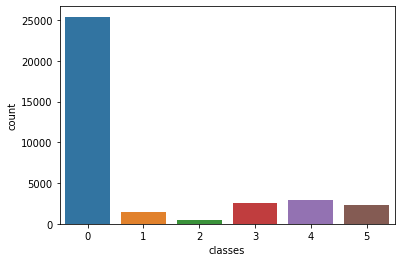

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(df.encode_cat)
plt.xlabel('classes');

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Class=0, n=25425 (72.356%)
Class=1, n=1454 (4.138%)
Class=2, n=454 (1.292%)
Class=3, n=2557 (7.277%)
Class=4, n=2906 (8.270%)
Class=5, n=2343 (6.668%)


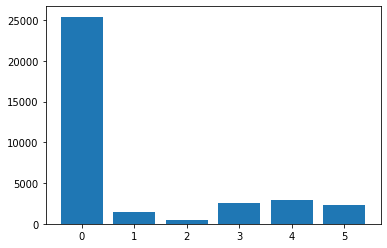

In [ ]:
# import imblearn
# from collections import Counter
# from matplotlib import pyplot
# X = df['sentence']
# y = df['encode_cat']
# counter = Counter(y)
# for k,v in counter.items():
# 	per = v / len(y) * 100
# 	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# # plot the distribution
# pyplot.bar(counter.keys(), counter.values())
# pyplot.show()

In [9]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 2e-5
bert_multilingual = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(bert_multilingual)

In [10]:
class SentimentDataset(Dataset):

  def __init__(self,dataframe,tokenizer,max_len):
    self.len = len(dataframe)
    self.data = dataframe
    self.tokenizer = tokenizer
    self.max_len = max_len 
  

  def __getitem__(self,index):
    sentence = str(self.data.sentence[index])
    sentence = " ".join(sentence.split())
    encoding = self.tokenizer.encode_plus(
        sentence,
        add_special_tokens = True,
        max_length = self.max_len,
        padding = 'max_length',
        return_token_type_ids = False,
        return_tensors = 'pt',
        truncation = True
    )
    #ids = encoding['input_ids']
    #mask = encoding['attention_mask']
    return {
        'ids' : encoding['input_ids'].flatten(),
        'mask': encoding['attention_mask'].flatten(),
        'targets': torch.tensor(self.data.encode_cat[index],dtype=torch.long)
    }

  def __len__(self):
    return self.len

In [11]:
train_size = 0.9
train_dataset = df.sample(frac=train_size,random_state=42)
test_dataset = df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print('Total no of entities in the dataset: {}'.format(df.shape))
print('Train dataset:{}'.format(train_dataset.shape))
print('Test dataset: {}'.format(test_dataset.shape))

training_set = SentimentDataset(train_dataset,tokenizer,MAX_LEN)
testing_set = SentimentDataset(test_dataset,tokenizer,MAX_LEN)

Total no of entities in the dataset: (35139, 3)
Train dataset:(31625, 3)
Test dataset: (3514, 3)


In [12]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [13]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = BertModel.from_pretrained("bert-base-multilingual-cased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 6)
        
    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [14]:
model = BERTClass()
model.to(device)

BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
   

In [ ]:
# weights = [0.28, 0.96, 0.99, 0.93, 0.92, 0.94]
# w = torch.tensor(weights)

In [15]:
loss_function = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(params= model.parameters(),lr = LEARNING_RATE)

In [16]:
def calcuate_accuracy(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [17]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [18]:
seed_val = 42
torch.manual_seed(seed_val)

In [19]:
def train(epoch):
  
  tr_loss = 0
  n_correct = 0
  nb_tr_steps = 0
  nb_tr_examples = 0
  model.train()
  start_time = time.time()
  for _,data in enumerate(training_loader, 0):
      ids = data['ids'].to(device, dtype = torch.long)
      mask = data['mask'].to(device, dtype = torch.long)
      targets = data['targets'].to(device, dtype = torch.long)

      outputs = model(ids, mask)
      loss = loss_function(outputs, targets)
      tr_loss += loss.item()
      big_val, big_idx = torch.max(outputs.data, dim=1)
      n_correct += calcuate_accuracy(big_idx, targets)

      nb_tr_steps += 1
      nb_tr_examples+=targets.size(0)
      
      optimizer.zero_grad()
      loss.backward()
      #When using GPU
      optimizer.step()

  print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
  epoch_loss = tr_loss/nb_tr_steps
  epoch_accu = (n_correct*100)/nb_tr_examples
  print(f"Training Loss Epoch: {epoch_loss}")
  print(f"Training Accuracy Epoch: {epoch_accu}")
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')

  return

In [20]:
for epoch in range(EPOCHS):
  train(epoch)
  print()

RuntimeError: ignored

In [ ]:
def valid(model,testing_loader):
  model.eval()
  n_correct = 0
  n_wrong = 0
  total = 0
  tr_loss = 0
  nb_tr_steps = 0
  nb_tr_examples = 0
  with torch.no_grad():
    for _,data in enumerate(testing_loader,0):
      ids = data['ids'].to(device,dtype = torch.long)
      mask = data['mask'].to(device,dtype = torch.long)
      targets = data['targets'].to(device,dtype=torch.long)
      outputs = model(ids,mask).squeeze()
      loss = loss_function(outputs,targets)
      tr_loss += loss.item()
      big_val,big_idx = torch.max(outputs.data,dim=1)
      n_correct += calcuate_accuracy(big_idx,targets)
      nb_tr_steps += 1
      nb_tr_examples += targets.size(0)

    epoch_loss = tr_loss/nb_tr_steps
    epoch_accuracy = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch:{epoch_loss}")
    print(f"Validation Accuracy Epoch:{epoch_accuracy}")

    return epoch_accuracy

In [ ]:
acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      #texts = d["sentences"]
      ids = d["ids"].to(device)
      mask = d["mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=ids,
        attention_mask=mask
      )
      _, preds = torch.max(outputs, dim=1)
      #sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model,testing_loader)

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred,zero_division=0))